<a href="https://www.nvidia.com/dli"> <img src="images/DLI Header.png" alt="Header" style="width: 400px;"/> </a>

# TensorFlow로 단어 생성하기

## 순환 신경망 (Recurrent Neural Networks) 소개

### 데이터 준비 (Data Preparation)

이 섹션에서는 이전 단어로부터 문장의 다음 단어를 예측하여 언어에 대한 이해를 생성하는 모델을 만들 것입니다. 

이전 실습에서는 레이블 된 이미지들로 구성된 데이터셋을 네트워크에 노출시켰습니다. 이번에는 **말뭉치(corpus)**를 학습하도록 설계된 네트워크에 많은 양의 텍스트들을 노출시킬 예정입니다.

우선 여러분은 영어라는 언어의 아주 조금의 부분이 되는 부분집합과 네트워크가 언어에 대해 알게 될 모든 것을 두 문장으로 표현한 작은 말뭉치를 사용하는 쉬운 예로부터 시작해보겠습니다. 여기서부터, 우리는 실제 세계를 더 잘 대표하기 위한 네트워크를 만들어낼 수 있게 될 것입니다.

첫째로 우리의 사전(아래의 셀을 클릭하고 Shift와 Enter 키를 눌러 코드를 실행합니다.):

In [1]:
small_dict=['EOS','a','my','sleeps','on','dog','cat','the','bed','floor'] #'EOS' means end of sentence.

다음으로, 우리는 네트워크에 언어를 학습시키기 위해 사용할 작은 말뭉치를 만들 수 있습니다. 우리 사전에 있는 단어들로 몇 개의 문장을 만들어 봅시다. numpy 배열 'X'의 첫 번째 벡터는 ['my','cat','sleeps','on','my','bed', 'EOS']를 나타냅니다. 

이 모델을 모델로 사용하여 **##FIXME##** vector를 ['a', 'dog', 'sleeps', 'on', 'the', 'floor', 'EOS'] 문장으로 대체하십시오.
이 시점에서, 우리는 힌트와 정의를 주는 새로운 방법을 소개하겠습니다. 힌트를 원한다면 [여기](#hint "The second line should be X=np.array([[2,6,3,4,2,8,0],[1,5,3,4,7,9,0]]),dtype=np.int32)")에 마우스를 올리세요. 앞으로 이 실습의 나머지 부분에서도 계속 확인 할 수 있게 될 것입니다.

In [3]:
import numpy as np #numpy is "numerical python" and is used in deep learning mostly for its n-dimensional array
# X=np.array([[2,6,3,4,2,8,0],[##FIXME##]],dtype=np.int32) 
X=np.array([[2,6,3,4,2,8,0],[1,5,3,4,7,9,0]],dtype=np.int32) 
    
# (#hint "The second line should be X=np.array([[2,6,3,4,2,8,0],[1,5,3,4,7,9,0]]),dtype=np.int32)")
print([small_dict[ind] for ind in X[1,:]]) #Feel free to change 1 to 0 to see the other sentence.

['a', 'dog', 'sleeps', 'on', 'the', 'floor', 'EOS']


이제 데이터를 확보했으므로 네트워크를 위해 데이터를 재구성해야 합니다. 단어는 기본적으로 이미지와 다른 유형의 데이터입니다. 28X28 그레이스케일 이미지는 각 셀이 해당 픽셀의 "그레이 정도(greyness)"를 나타내는 28X28 매트릭스로 표시됩니다. 256X256 컬러 이미지는 각 셀에 각 픽셀의 "적색", "녹색", "청색"이 포함된 `256X256X3` [tensor](#tensor "a vector, matrix, or any other *block* of n-dimensional data")"로 표시됩니다.

우리는 이미지를 분류할 때 입력 tensor가 확률 벡터(vector of probabilities)로 어떻게 바뀌는 지를 설명하기 위해 TensorFlow(또는 다른 프레임워크)를 사용하였습니다.
단어를 입력으로 사용하려면 먼저 단어를 tensor로 변환해야 합니다. 이 예에서는 각 단어가 하나의 '1'과 그 외는 '0'인 벡터로 표시되는 "one-hot encoding"을 사용합니다. 이 vector 값들은 단어에 따라 특정 위치에 하나의 '1'을 갖는 사전의 길이(length of the dictionary)가 됩니다.

이제 TensorFlow [세션](#sess "where computational graphs described in TensorFlow are run")을 실행하여 입력 데이터를 one-hot encoding으로 변환하고, 어떻게 보이는지 시각화 해보겠습니다. TensorFlow의 embedding_lookup 및 unstack 함수를 사용하면 쉽게 작업을 수행할 수 있습니다. One-hot encoding의 경우, 사전과 입력 데이터셋의 길이로 구성된 [identity matrix](#idmat "A matrix with ones in the diagonal and zeros everywhere else")인 embedding_lookup을 전달합니다. 이 작업은 실습의 일부로 수행될 수도 있지만, 입력을 더 잘 시각화하기 위해 따로 진행하도록 하겠습니다.

우리가 사용하고 있는 영어의 하위 집합(subset)이 얼마나 작은지를 상기하기 위해, **##FIXME##**을 사전의 길이로 대체합니다. 힌트를 얻기 원한다면, [여기](#dict_length "np.identity function내의 ##FIXME##를 len(small_dict)으로 고치세요.")에 마우스를 올리세요.


In [4]:
import tensorflow as tf
from tensorflow.python.framework import ops

tf.reset_default_graph()
init_op = tf.group(tf.global_variables_initializer(),
                   tf.local_variables_initializer())    


with tf.Session() as sess:
        
        sess.run(init_op)
        coord = tf.train.Coordinator()
        threads = tf.train.start_queue_runners(coord=coord)
        
#         result=tf.nn.embedding_lookup(np.identity(##FIXME##), X).eval()
        result=tf.nn.embedding_lookup(np.identity(len(small_dict)), X).eval()
        #dict_length "np.identity function내의 ##FIXME##를 len(small_dict)으로 고치세요.
        
        # embedding_lookup이 알아서 one-hot encoding으로 바꿔줍니다.
        
        
        example_input=sess.run([tf.unstack(result,X.shape[1],1)])
        coord.request_stop()
        coord.join(threads)
        sess.close()
print('one-hot encoded inputs')
print(result)
print('shape of the input')
print(result.shape)
print('reshaped input for training')
print(example_input)

one-hot encoded inputs
[[[0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
  [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
  [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
  [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]

 [[0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
  [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
  [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
  [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]]
shape of the input
(2, 7, 10)
reshaped input for training
[[array([[0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.]]), array([[0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0.]]), array([[0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.]]), array([[0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.]]), array([[0., 0., 1., 0., 0., 0., 0., 0

이제 우리 데이터가 생겼습니다!

신경망이 랜덤화 된 값으로 채워지기 시작했음을 기억하십시오. 데이터 노출을 통해 네트워크는 입력에서 출력까지의 정확한 매핑을 만들기 위해 "학습" 합니다.

### 단어 생성 워크플로우 (Word Generation)

여러분의 이미지 분류 네트워크의 출력 레이블은 이미지 입력으로부터 예측됩니다. 우리의 언어 처리 네트워크는 이전 단어의 입력으로부터 다음 단어 예측을 출력해낼 것입니다.

예를 들어, 문장을 가지고 직접 해보겠습니다.

우리의 문장은 "나의(My)"로 시작합니다.

여러분이 알고 있는 모든 단어들과 일생 동안 관찰해 온 패턴을 생각해 봤을 때, "My"라는 단어 뒤에는 어떤 단어가 나올 수 있을까요?

좋습니다. 이제 여러분이 추측했으니, 두 번째 단어가 "친구(friend)"라는 것을 알게 됩니다.

이 문장에 대해 조금 더 배우고, 첫 두 단어를 사용하여 문장의 세 번째 단어를 추측할 수 있습니다.

그 다음 여러분은 세 번째 단어가 "went"라는 것을 예측하고, 오류를 범했다면, 다시 추측하게 됩니다. 여러분은 이 문장 구조에 대해 처음 생각했던 것보다 더 많이 알고 있습니까? 만약 여러분이 이 문장을 처음 보았거나, 또는 몇 천번 쯤 본 문장이건 간에, 여러분은 아마도 모든 문장 구조에 대해서도 더 많이 알고 있을 것입니다.

이것은 네트워크가 언어에 대해 배우는 방식과 유사합니다. 이러한 유형의 네트워크를 **순환 신경망(RNN)**이라고 합니다. RNN은 충분한 시간과 데이터셋이 있다면, 어떻게 "주어"가 "동사"와 관련 있는지, 언제 구두점들이 보통 필요한지 등 모든 경우의 수를 학습할 수 있습니다. RNN은 예측한 다음 단어와 실제 다음 단어 사이의 오류를 줄여가면서 학습합니다. RNN들은 예측을 가능하게 한 단어들을 "기억"하여 문장의 구조를 형성합니다.

여러분이 사용할 수 있는 가장 간단한 RNN에서 단 하나의 레이어만 가지고, 약 8개의 단어로 이루어진 두 문장에서 각 단어 사이의 관계가 무엇인지를 배울 수 있는지를 봅시다.
아래의 **##FIXME##**을 숫자 10으로 바꾸어 10개의 epoch로 시작하겠습니다.

In [9]:
# 여기가 실제로 학습시키는 코드


# epochs=##FIXME##
epochs=10
plot_loss=[]
num_hidden=24
num_steps=X.shape[1]
dict_length=len(small_dict)
batch_size=2
tf.reset_default_graph()

## Make Variables
variables_dict = {
    "weights1":tf.Variable(tf.truncated_normal([num_hidden,dict_length],stddev=1.0,dtype=tf.float32),name="weights1"),
    "biases1": tf.Variable(tf.truncated_normal([dict_length],stddev=1.0,dtype=tf.float32), name="biases1")}
# w와 b가 어떤식으로 define 되어있는지


# Create input data
X_one_hot=tf.nn.embedding_lookup(np.identity(dict_length), X) #[batch,num_steps,dictionary_length][2,6,7]
y=np.zeros((batch_size,num_steps),dtype=np.int32)
y[:,:-1]=X[:,1:]
y_one_hot=tf.unstack(tf.nn.embedding_lookup(np.identity(dict_length), y),num_steps,1) #[batch,num_steps,dictionary_length][2,6,7]

y_target_reshape=tf.reshape(y_one_hot,[batch_size*num_steps,dict_length])

#Create our LSTM
# 여기가 architecture를 선언하는 부분. LSTM을 선언하고 한 층을 쌓고, 쌓은 것으로 RNN을 만들고

cell = tf.contrib.rnn.LSTMCell(num_units=num_hidden, state_is_tuple=True)
# 셀 선언. 

outputs, last_states = tf.contrib.rnn.static_rnn(
    cell=cell,
    dtype=tf.float32,
    inputs=tf.unstack(tf.to_float(X_one_hot),num_steps,1))

output_reshape=tf.reshape(outputs, [batch_size*num_steps,num_hidden]) #[12==batch_size*num_steps,num_hidden==12]
pred=tf.matmul(output_reshape, variables_dict["weights1"]) +variables_dict["biases1"]

# Define loss and optimizer
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=pred, labels=y_target_reshape))
optimizer = tf.train.AdamOptimizer(0.01).minimize(cost)

init_op = tf.group(tf.global_variables_initializer(),
                   tf.local_variables_initializer())    

plot_loss=[]

with tf.Session() as sess:
        # 실제로 학습이 되는 부분
        
        sess.run(init_op)
        coord = tf.train.Coordinator()
        threads = tf.train.start_queue_runners(coord=coord)        
        for i in range(epochs):
            loss,_,y_target,y_pred,output=sess.run([cost,optimizer,y_target_reshape,pred,outputs])
            plot_loss.append([loss])

            if i% 5 ==0:
                print("iteration: ",i," loss: ",loss)
                
        print(y_target)
        print(np.argmax(y_pred,1))          
        coord.request_stop()
        coord.join(threads)
        sess.close()  

('iteration: ', 0, ' loss: ', 2.7247705)
('iteration: ', 5, ' loss: ', 1.9134545)
[[0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
[5 5 2 5 0 0 0 0 0 0 0 0 0 0]


여러분의 RNN은 두 문장을 10번 보았습니다. RNN은 새로운 단어를 볼 때마다 다음 단어를 예측하려고 시도합니다. TensorFlow가 ~ 2.15의 예측에 "손실(loss)" 또는 오류(error)를 보여주고 있습니다. 샘플 문장을 통해 이것이 무엇인지 한 번 봅시다.

In [16]:
#Lets look at one input data point at each step and its prediction
print("Input Sentence")
sn=0 #The sentence number
print([small_dict[ind] for ind in X[sn,:]])
print("Predicted Words")
print([small_dict[ind] for ind in np.argmax(y_pred[sn::2],1)])


print('정답 : cat, sleeps, on, my, bed, EOS, EOS')

Input Sentence
['my', 'cat', 'sleeps', 'on', 'my', 'bed', 'EOS']
Predicted Words
['cat', 'sleeps', 'on', 'my', 'bed', 'EOS', 'EOS']
정답 : cat, sleeps, on, my, bed, EOS, EOS


위 출력은 각 "예측 단어(Predicted Word)"가 "입력 문장(Input Sentence)"에서 적합한 단어로 예측되었음을 알 수 있습니다. 예를 들어, 첫 번째 "예측 단어(Predicted Word)"는 "나의(My)"라는 입력 단어를 따라 예측되었고, 두 번째 예측 단어는 "나의 고양이(My cat)"라는 두 단어를 따라 예측되었다.
우리는 적어도 학습에 사용되는 문장들을 예측할 수 있을까요? 문장의 첫 단어를 전달하여 얻은 결과값은 여러분의 원래 문장이 되어야 합니다. 무슨 일이 생겼습니까?

### 성능 향상

#### 추가 실습

코드 블록의 반복 횟수를 300개로 증가해 보십시오. 이것이 원래 문장을 예측하는 네트워크의 능력에 어떻게 영향을 미치는가요?
학습 시간이 늘어나면 물론 성능을 향상시킬 수 있습니다. 하지만, 우리가 여전히 너무 작은 크기의 (장난감 수준의) 데이터셋을 사용하고 있다는 것을 기억하세요.

#### 심층 네트워크 

여러분의 작은 샘플에서 문장을 완벽하게 예측할 수 있었겠지만, 다음에는 좀 더 복잡한 예를 들어 보겠습니다. 이제 성능에 영향을 미칠 수 있는 몇 가지 레버(lever), 즉 네트워크의 깊이와 "드롭아웃(dropout)"이라는 작업을 살펴보겠습니다.
심층 모델은 더 복잡한 기능을 의미합니다. TensorFlow에서 심층 모델을 구축하기 원한다면, 여러분은 레이어를 여러 겹으로 만들면 됩니다.

RNN을 2개, 4개 레이어로 학습시켜봅시다. RNN의 레이어 수를 변경하려면 어떤 매개변수를 설정해야 합니까? 힌트를 보려면 [여기](#정답1 "num_layers=2 or 4. 이는 lstm_cell들이 생성되는 'for' loop에서 사용됩니다.")에 마우스를 올리세요.

드롭아웃은 실제로 모델이 학습 중에도 일부 매개 변수를 "잊어버려(forget)"라고 요청하여 모델의 일반화 능력을 향상시킵니다. 드롭아웃 값을 조정할 수 있는 위치를 보려면, [여기](#정답2 "dropout = ___, 1.0이면 = none -remember everything 그리고 0.0이면 all -remember nothing의 의미를 갖습니다. dropout은 다음의 줄의 code에서 사용됩니다. lstm_cell = tf.contrib.rnn.DropoutWrapper(lstm_cell,input_keep_prob=dropout,output_keep_prob=dropout)")에 마우스를 올리세요.
이 둘을 실험해서 성능 향상이 가능한지 알아보세요.

In [19]:
#Now let's try multiple layers 
plot_loss2=[]
num_hidden=24
num_steps=X.shape[1]
dict_length=len(small_dict)
batch_size=2
# num_layers=##FIXME##
num_layers=4
tf.reset_default_graph()

## Make Variables
variables_dict = {
    "weights1":tf.Variable(tf.truncated_normal([num_hidden,dict_length],stddev=1.0,dtype=tf.float32),name="weights1"),
    "biases1": tf.Variable(tf.truncated_normal([dict_length],stddev=1.0,dtype=tf.float32), name="biases1")}


# Create input data
#small_dict=['EOS','i','will','walk','the','dog','cat','run']
#X=np.array([[1,2,7,4,5,0],[1,2,3,4,6,0]],dtype=np.int32)  
X_one_hot=tf.nn.embedding_lookup(np.identity(dict_length), X) 
y=np.zeros((batch_size,num_steps),dtype=np.int32)
y[:,:-1]=X[:,1:]
y_one_hot=tf.unstack(tf.nn.embedding_lookup(np.identity(dict_length), y),num_steps,1) 
y_target_reshape=tf.reshape(y_one_hot,[batch_size*num_steps,dict_length])
# dropout = ##FIXME##
dropout = 1
# dropout = 0.5


##################### Create a multilayer RNN ####################
layer_cell=[]
for _ in range(num_layers):
    lstm_cell = tf.contrib.rnn.LSTMCell(num_units=num_hidden, state_is_tuple=True)
    lstm_cell = tf.contrib.rnn.DropoutWrapper(lstm_cell,
                                          input_keep_prob=dropout,
                                          output_keep_prob=dropout)
    layer_cell.append(lstm_cell)

cell = tf.contrib.rnn.MultiRNNCell(layer_cell, state_is_tuple=True)
outputs, last_states = tf.contrib.rnn.static_rnn(
    cell=cell,
    dtype=tf.float32,
    inputs=tf.unstack(tf.to_float(X_one_hot),num_steps,1))

output_reshape=tf.reshape(outputs, [batch_size*num_steps,num_hidden])
pred=tf.matmul(output_reshape, variables_dict["weights1"]) +variables_dict["biases1"]

cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=pred, labels=y_target_reshape))
optimizer = tf.train.AdamOptimizer(0.01).minimize(cost)


init_op = tf.group(tf.global_variables_initializer(),
                   tf.local_variables_initializer())    


with tf.Session() as sess:
        
        sess.run(init_op)
        coord = tf.train.Coordinator()
        threads = tf.train.start_queue_runners(coord=coord)
        for i in range(300):
            loss,_,y_target,y_pred,output=sess.run([cost,optimizer,y_target_reshape,pred,outputs])
            plot_loss2.append([loss])
            
            if i% 25 ==0:
                print("iteration: ",i," loss: ",loss)
                
        print(y_target)
        print(np.argmax(y_pred,1))         
        coord.request_stop()
        coord.join(threads)
        sess.close()    


('iteration: ', 0, ' loss: ', 2.6045303)
('iteration: ', 25, ' loss: ', 1.0563842)
('iteration: ', 50, ' loss: ', 0.4670295)
('iteration: ', 75, ' loss: ', 0.22977774)
('iteration: ', 100, ' loss: ', 0.10870053)
('iteration: ', 125, ' loss: ', 0.010678169)
('iteration: ', 150, ' loss: ', 0.002501288)
('iteration: ', 175, ' loss: ', 0.001614981)
('iteration: ', 200, ' loss: ', 0.001240606)
('iteration: ', 225, ' loss: ', 0.0010056081)
('iteration: ', 250, ' loss: ', 0.00083935895)
('iteration: ', 275, ' loss: ', 0.00071514456)
[[0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
[6 5 

#### 단일/다계층 RNN의 loss를 비교하십시오.

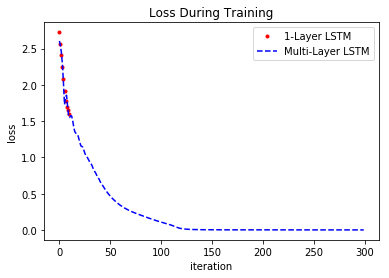

In [20]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(plot_loss,'r.')
plt.plot(plot_loss2,'b--')
plt.legend(["1-Layer LSTM","Multi-Layer LSTM"])
plt.ylabel("loss")
plt.xlabel("iteration")
plt.title("Loss During Training")
plt.show()

여러분의 모델은 이 두 문장은 잘 완성할 수 있지만, 언어에 대한 나머지 부분에 대해서는 아무것도 모릅니다. (마치 노래 한 곡의 단 두 단락을 배운 것과 같습니다.) 일반적으로, 우리가 언어를 이해하기 위해 노력할 때, 모델의 복잡성(깊이)을 높여 더 복잡한 [말뭉치(corpus)](#corpora "actually corpora")들에 대해 배울 수 있겠지만, 이로 인해 오히려 **overfitting** 문제를 발생시킬 수도 있습니다. 여기서 드롭아웃은 오버피팅을 줄이는 한 방법입니다. 우리가 특정 유형의 언어나 캡션에 대해 배울 때 이러한 전략을 잘 기억하고 있어야 할 것입니다.

### MSCOCO 캡션 데이터셋을 사용하여 RNN  모델 학습시키기
이제 MSCOCO [Microsoft Common Objects in Context](http://mscoco.org/)의 이미지 캡션 데이터셋을 사용하여 RNN 모델이 캡션을 이해하도록 학습시키겠습니다. 아래는 데이터를 읽고, 포맷하고, TensorFlow에 공급하는 한 방법을 보여줍니다. 먼저 캡션 파일을 읽은 다음, 구두점을 제거 후 학습시킵니다. 시간 제약 상, 이번 실습에서는 전체 데이터셋을 사용하지 않습니다. 하지만, 이 부분은 더 많은 데이터셋 또는 전체 데이터셋으로 바꾸어 학습하기 쉽습니다. 이를 쉽게 하는 방법을 여러분은 알고 계십니까?

In [21]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
import inspect
import time

from tensorflow.python.framework import dtypes
#import reader
import collections
import os
import re
import json

num_steps=20
## Read Training files
with open("/dli/data/mdt/mscoco/captions_train2014.json") as data_file:
         data=json.load(data_file)

TotalNumberofCaptions=len(data['annotations'])

sentences=[]

##Create a list of all of the sentences.
for i in range(TotalNumberofCaptions):
        sentences+=[re.sub('[^A-Za-z0-9]+',' ',data['annotations'][i]['caption']).lower()]

TotalWordList=[]
for i in range(TotalNumberofCaptions):
        TotalWordList+=re.sub('[^A-Za-z0-9]+',' ',data['annotations'][i]['caption']).lower().split()

#Determine number of distinct words 
distinctwords=collections.Counter(TotalWordList)
#Order words 
count_pairs = sorted(distinctwords.items(), key=lambda x: (-x[1], x[0])) #ascending order
words, occurence = list(zip(*count_pairs))
DictionaryLength=occurence.index(4) #index for words that occur 4 times or less
words=['PAD','UNK','EOS']+list(words[:DictionaryLength])
word_to_id=dict(zip(words, range(len(words))))
#Tokenize Sentence
Tokenized=[]
for full_words in sentences:
        EmbeddedSentence=[word_to_id[word] for word in full_words.split() if word in word_to_id]+[word_to_id['EOS']]
        #Pad sentences that are shorter than the number of steps 
        if len(EmbeddedSentence)<num_steps:
            b=[word_to_id['PAD']]*num_steps
            b[:len(EmbeddedSentence)]=EmbeddedSentence
        if len(EmbeddedSentence)>num_steps:
            b=EmbeddedSentence[:num_steps]
        if len(b)==EmbeddedSentence:
            b=EmeddedSentence
        b=[word_to_id['UNK'] if x>=DictionaryLength else x for x in b] #turn all words used 4 times or less to 'UNK'
        #print(b)
        Tokenized+=[b]

우리는 이러한 캡션을 "토큰화(tokenize)"하거나 각 단어를 숫자(인기 기준 내림차순)로 변환할 수 있습니다. 또한 문장의 길이는 다양하기 때문에 표준 입력과 출력 tensor를 만들기 위해 짧은 문장에는 0을 채워 넣고, 긴 문장은 잘라냈습니다.

In [22]:
############################################# Parameters #####################################################

num_hidden=256
num_steps=20
dict_length=len(words)
batch_size=4


## Create labels
Label=[]
for caption in Tokenized:
    Label+=[caption[1:]+[word_to_id['PAD']]]

NumberofCasestoEvaluate=20
TrainingInputs=Tokenized[:NumberofCasestoEvaluate]
LabelInputs=Label[:NumberofCasestoEvaluate]

#Print out some variables 
print(TrainingInputs[0])
#첫단어부터 끝단어까지

print(LabelInputs[0])
# 정답을 표시하는거, 첫단어 빼고 나머지 단어 label

print("Number of words in this dictionary", len(words))

[3, 142, 508, 9, 619, 415, 276, 57, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[142, 508, 9, 619, 415, 276, 57, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Number of words in this dictionary 8768


여러분은 다음 두 가지를 알 수 있습니다.
1. 우리의 [라벨](#labels "labels are the outputs that we want our network to generate")은 training 세트에서 다음으로 나오는 *토큰(token)*입니다. 
2. 이 사전(dictionary)은 사실 훨씬 더 큽니다.

우리는 학습 시간에 더 큰 혜택을 얻기 위해 병렬 프로세싱과 추가 GPU를 사용하여 4개의 배치(`batch_size`)로 데이터를 네트워크에 제공하겠습니다.

In [23]:
#Create our input queue
def data_input_queue(TrainingInputs, LabelInputs, num_steps):
    train_input_queue = tf.train.slice_input_producer(
                                    [TrainingInputs, LabelInputs],
                                    shuffle=True)

    ##Set our train data and label input shape for the queue
    TrainingInput=train_input_queue[0]
    LabelInput=train_input_queue[1]
    TrainingInput.set_shape([num_steps])
    LabelInput.set_shape([num_steps])
    min_after_dequeue=100000
    capacity = min_after_dequeue + 3 * batch_size 
    #input_x, target_y
    train_x, train_y = tf.train.batch([TrainingInput, LabelInput],
                                                 batch_size=batch_size ,
                                                 capacity=capacity,
                                                 num_threads=4)
    return train_x, train_y

이제 MSCOCO 캡션으로 RNN을 학습시킬 준비가 되었습니다. 자유롭게 레이어 수를 변경하여 실습하고, 다시 드롭아웃을 수행해 보십시오.

In [24]:
tf.reset_default_graph()
num_layers=1
dropout = 1.0

loss_mscoco=[]
#######################################################################################################
TrainingInputs=Tokenized[:NumberofCasestoEvaluate]
LabelInputs=Label[:NumberofCasestoEvaluate]


variables_dict = {
    "weights_mscoco":tf.Variable(tf.truncated_normal([num_hidden,dict_length],
                                                     stddev=1.0,dtype=tf.float32),name="weights_mscoco"),
    "biases_mscoco": tf.Variable(tf.truncated_normal([dict_length],
                                                     stddev=1.0,dtype=tf.float32), name="biases_mscoco")}


# Create input data
train_x, train_y =data_input_queue(TrainingInputs, LabelInputs, num_steps)
mscoco_dict=words
X_one_hot=tf.nn.embedding_lookup(np.identity(dict_length), train_x) #[batch,num_steps,dictionary_length]
y_one_hot=tf.unstack(tf.nn.embedding_lookup(np.identity(dict_length), train_y),num_steps,1)#[batch,num_steps,dictionary_length]
#임베딩 룩업테이블

y_target_reshape=tf.reshape(y_one_hot,[batch_size*num_steps,dict_length])

input_keep_prob=dropout
output_keep_prob=dropout

#Create a multilayer RNN

layer_cell=[]
for _ in range(num_layers):
    lstm_cell = tf.contrib.rnn.LSTMCell(num_units=num_hidden, state_is_tuple=True)
    ############# add dropout #########################
    lstm_cell = tf.contrib.rnn.DropoutWrapper(lstm_cell,
                                          input_keep_prob=dropout,
                                          output_keep_prob=dropout)
    layer_cell.append(lstm_cell)

cell = tf.contrib.rnn.MultiRNNCell(layer_cell, state_is_tuple=True)
# RNN 쌓는거

outputs, last_states = tf.contrib.rnn.static_rnn(
    cell=lstm_cell,
    dtype=tf.float32,
    inputs=tf.unstack(tf.to_float(X_one_hot),num_steps,1))

output_reshape=tf.reshape(outputs, [batch_size*num_steps,num_hidden])
pred=tf.matmul(output_reshape, variables_dict["weights_mscoco"]) +variables_dict["biases_mscoco"]
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=pred, labels=y_target_reshape))
optimizer = tf.train.AdamOptimizer(0.01).minimize(cost,aggregation_method = tf.AggregationMethod.EXPERIMENTAL_TREE)


init_op = tf.group(tf.global_variables_initializer(),
                   tf.local_variables_initializer())    


with tf.Session() as sess:
        
        sess.run(init_op)
        coord = tf.train.Coordinator()
        threads = tf.train.start_queue_runners(coord=coord)

        for i in range(1500):
            x_input,y_input=sess.run([train_x, train_y])
            loss,_,y_target,x_input,y_input,y_pred=sess.run([cost,optimizer,y_target_reshape,train_x, train_y,pred])
            loss_mscoco.append([loss])
            if i% 100==0:
                print("iteration: ",i, "loss: ",loss)  
        print("Done Training")
        coord.request_stop()
        coord.join(threads)
        sess.close()    

iteration:  0 loss:  8.822754
iteration:  100 loss:  0.121202126
iteration:  200 loss:  0.09813916
iteration:  300 loss:  0.12715036
iteration:  400 loss:  0.095678665
iteration:  500 loss:  0.11264532
iteration:  600 loss:  0.12753458
iteration:  700 loss:  0.07022795
iteration:  800 loss:  0.13134536
iteration:  900 loss:  0.11306753
iteration:  1000 loss:  0.10637943
iteration:  1100 loss:  0.12407749
iteration:  1200 loss:  0.087161444
iteration:  1300 loss:  0.115499035
iteration:  1400 loss:  0.1108933
Done Training


In [25]:
#Lets look at one input data point and its prediction
print("Input Sentence")
batch_element=2
print([words[ind] for ind in x_input[batch_element,:]])
print("Target")
print([words[ind] for ind in y_input[batch_element,:]])
print("Predicted words")
print([words[ind] for ind in np.argmax(y_pred[batch_element::batch_size],1)])

#predict가 target하고 똑같으면 된다.

Input Sentence
[u'a', u'panoramic', u'photo', u'of', u'a', u'kitchen', u'and', u'dining', u'room', 'EOS', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD']
Target
[u'panoramic', u'photo', u'of', u'a', u'kitchen', u'and', u'dining', u'room', 'EOS', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD']
Predicted words
[u'panoramic', u'view', u'of', u'a', u'kitchen', u'and', u'dining', u'room', 'EOS', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD']


여러분은 지금까지 이전 단어에서 다음 단어를 예측하기 위해 RNN을 사용하는 법과 RNN의 언어에 대한 이해를 공부했습니다.

이 모델을 구현하여 어떤 문제를 해결할 수 있을까요?

만약 여러분이 이것을 정말 잘 활용할 수 있는 실력을 키운다면, 우리는 다른 사람의 작문 스타일을 흉내내거나, 과거의 실적을 바탕으로 주식시장을 예측한다거나, 문자 메시지에서 다음 단어를 제안하기 시작할 수 있습니다. 

하지만 지금까지 실습한 수준의 네트워크에서 한 단어(word) 이상을 출력하도록 시도했다면, 그 성과는 매우 실망스러웠을 것입니다. 

여러분의 네트워크가 전체 문장(sentence)을 생성하도록 하기 위한 한가지 방법은 어떤 맥락을 제공하는 것입니다. 다음 장에서는 네트워크가 이미지를 이해하도록 하는 법을 배우도록 하겠습니다.

## References 
[1] Imanol Schlab. TensorFlow Input Pipeline Example. http://ischlag.github.io/

[2] Denny Britz. Practical Examples for RNNs in TensorFlow https://github.com/dennybritz/tf-rnn

[3]Lin, Tsung-Yi, et al. "Microsoft coco: Common objects in context." European Conference on Computer Vision. Springer International Publishing, 2014.